In [360]:
import numpy as np 
import random
import math

<h2>Data Structures for Algorithm</h2>

The Stoer-Wagner Algorithm for optimal minimum cuts is implemented using the following Data Structures: 
Graph data structure with adjacency matrix 
Disjoint-set data structure to find the sets of the cut
Priority-Queue implemented using Binary Heap to find s-t Minimum Cuts  

In [361]:
# class representing weighted directed edge
class Edge:
    def __init__(self, src: int, dst: int, w: int):
        self.src = src 
        self.dest = dst
        self.weight = w 
    def __str__(self):
        return "("+str(self.src)+","+str(self.dest)+", w="+str(self.weight)+")"     

In [362]:
class Cut: 
    def __init__(self, rep1: set, rep2: set, weight: int):
        self.weight = weight
        self.rep1 = rep1
        self.rep2 = rep2

In [363]:
class UnionFind:
    def __init__(self, V: int):
        self.sets = {i:i for i in range(1,V+1)}
        self.reps = {i for i in range (1,V+1)}
        self.V = V


    # find root-parent of set 
    def Find(self, v: int):
        if self.sets[v] == v: 
            return v
        rep = self.Find(self.sets[v]) # representative of set
        self.sets[v] = rep
        return rep 
           
    def Union(self, v1: int, v2: int):
        self.sets[v2] = self.Find(v1)
        self.reps.remove(v2)
        
    def get_sets(self):
        return self.reps
       
    def copy(self): 
        uf = UnionFind(self.V)
        uf.sets = self.sets.copy()
        uf.reps = self.reps.copy()  
        
    def print(self): 
        print(self.sets)
        print(self.reps)      
    
           


Class for Undirected Weighted Graph represented by Adjacency Matrix

In [364]:
class Graph:
    def __init__(self, V: int, edges=[], file_name=""):
        self.edges = edges    # list of all edges of the graph 
        self.n = self.V =  V            # number of vertices  
        self.E = len(edges)
        self.adj_matrix = np.zeros(shape=(V+1,V+1), dtype=int)
        self.Degree = np.zeros(V+1, dtype=np.int32)        
        self.unionFind = UnionFind(V)
        self.not_contracted = {i for i in range(1,V+1)}  # set containing vertices not contracted in G
        self.file_name = file_name
        self.Degree_test = np.zeros(V+1, dtype=np.int32)
        for edge in edges: 
            i = edge.src
            j = edge.dest
            self.adj_matrix[i][j] = self.adj_matrix[j][i] = edge.weight
            self.Degree[i] += edge.weight
            self.Degree[j] += edge.weight
            self.Degree_test[i] += edge.weight
            self.Degree_test[j] += edge.weight       
                



    def contract_edge(self, src: int , dst: int):         
        new_vertex, contracted =  (src,dst) if src<dst else (dst,src)
        w = self.adj_matrix[src][dst]
              
        self.unionFind.Union(new_vertex,contracted)
        self.adj_matrix[new_vertex][contracted] = self.adj_matrix[contracted][new_vertex] = 0 # Delete contracted edge (weight=0)
        self.Degree[new_vertex] += self.Degree[contracted]-2*w   # update Degree array 
        self.Degree[contracted] = 0 

        # adding weights to new vertex(after contraction)
        # deleting edges of contracted vertex
        for i in range(1,self.n+1):
            self.adj_matrix[new_vertex][i] += self.adj_matrix[contracted][i]
            self.adj_matrix[i][new_vertex] += self.adj_matrix[i][contracted]  # add weights of edges from contracted vertex
            self.adj_matrix[i][contracted] = self.adj_matrix[contracted][i] = 0 # delete in-going and out-going edges of contracted vertex      
        self.not_contracted.remove(contracted)    
    
    def Cut(self):
        sets = list(self.unionFind.get_sets())  # dict contains sets - mapping between vertex to all the vertices that contracted to itself.
        if len(sets) != 2: 
            return None 
        s , t = sets[0] , sets[1]    
        
        weight = self.Degree[t]
        return Cut(s,t,weight)      
       
    def copy(self):
        g_copy = Graph(self.n)
        g_copy.unionFind = self.unionFind.copy()        
        g_copy.Degree = self.Degree.copy()
        g_copy.adj_matrix = self.adj_matrix.copy()
        g_copy.not_contracted = self.not_contracted.copy()
        g_copy = self.E
        
        return g_copy  
        

In [365]:
''' Element in Heap '''
class Vertex: 
  def __init__(self,v: int):
    self.vertex = v 
    self.weight = 0
  def __str__(self):
    return 'w={}'.format(self.weight)   

class maxPriorityQ:
    '''
    PQ implemented with binary max-heap
    the heap will sort the elements by the total weights connecting the vertex to the outside 
    '''
    # ctor
    def __init__(self, not_contracted: set):
        self.size = len(not_contracted)
        self.heap = [Vertex(v) for v in not_contracted] # first vertex is 1       
        self.vertex_to_heap = {self.heap[i].vertex:i for i in range(self.size)}  # vertex to index at heap mapping; will be used in updating weights to vertex
        
    # Remove maximum element from the queue    
    def extractMax(self):
        if self.size == 0:
            return None
        root = self.heap[0]
        leaf = self.heap[self.size-1].vertex
        self.vertex_to_heap[root.vertex] = -1
        self.vertex_to_heap[leaf] = 0 
        self.heap[0] = self.heap[self.size-1]
        self.size -= 1 
        self.heapify()
        return root

    def left(self, index: int):
        if index*2 < self.size:
            return self.heap[index*2].weight
        return None

    def right(self, index: int):
        if index*2+1 < self.size:
            return self.heap[index*2+1].weight
        return None    

    def swap(self, ind1,ind2):
        v1 , v2 = self.heap[ind1].vertex, self.heap[ind2].vertex
        tmp = self.heap[ind1]
        self.heap[ind1] = self.heap[ind2]
        self.heap[ind2] = tmp 
        self.vertex_to_heap[v1] = ind2 
        self.vertex_to_heap[v2] = ind1         

    def heapify(self, root = 0):
        sons = [self.left(root), self.right(root)]               
        if sons[0] is None:
            return
        max = 2*root   # maximum set to left son        
          
        if sons[1] is not None and sons[1] >= sons[0]:
            max = 2*root + 1 # maximum set to right son
        if self.heap[max].weight > self.heap[root].weight:
            self.swap(max,root)
            self.heapify(max)
        return 

    def updateAtIndex(self, vertex: int, weight: int):         
        index = self.vertex_to_heap[vertex]
        if index == -1: 
            return
        self.heap[index].weight = self.heap[index].weight + weight
        
    def buildHeap(self):
        startIndex = self.size // 2 -1  
        for i in range(startIndex, -1,-1):
            self.heapify(i)

    def print(self): 
        for i in range(self.size):
            print(self.heap[i], end="")
        print(' ')                             





Parsing/Generating Graphs for txt files 

please modify the path variable to the current directory of dataset

In [366]:
import os 
path = "."  # modify

def generate_graph(file_name):
    with open(file_name) as f:       
        line = f.readline()
        n_vertices,m_edges = [int(token) for token in line.split()]
        edges = [] 
        for _ in range(m_edges):
            line = f.readline()
            src,dst,w = (int(token) for token in line.split())
            edges.append(Edge(src,dst,w))
    return Graph(n_vertices,edges ,os.path.splitext(file)[0].lower())        

graphs = [] 
for file in os.listdir(path): 
    ext = os.path.splitext(file)[-1].lower()
    if ext != ".txt":
      continue  
    g = generate_graph(path+"/"+str(file))    
    graphs.append(g)
    print('Created Graph from input-file {}'.format(str(file)))
print('{} Graphs Created!'.format(len(graphs)))    


Created Graph from input-file input_random_01_10.txt
Created Graph from input-file input_random_02_10.txt
Created Graph from input-file input_random_03_10.txt
Created Graph from input-file input_random_04_10.txt
Created Graph from input-file input_random_05_20.txt
Created Graph from input-file input_random_06_20.txt
Created Graph from input-file input_random_07_20.txt
Created Graph from input-file input_random_08_20.txt
Created Graph from input-file input_random_09_40.txt
Created Graph from input-file input_random_10_40.txt
Created Graph from input-file input_random_11_40.txt
Created Graph from input-file input_random_12_40.txt
Created Graph from input-file input_random_13_60.txt
Created Graph from input-file input_random_14_60.txt
Created Graph from input-file input_random_15_60.txt
Created Graph from input-file input_random_16_60.txt
Created Graph from input-file input_random_17_80.txt
Created Graph from input-file input_random_18_80.txt
Created Graph from input-file input_random_19_

<h2>
The Stoer-Wagner algorithm
</h2>

In [367]:
def stMinCut(G: Graph):   
    priority_q = maxPriorityQ(G.not_contracted)  
    S = []
    
    while len(S) < len(G.not_contracted):       
        max = priority_q.extractMax()
        S.append(max)
        # iterate over all neighbors
        for i in G.not_contracted:  
            v = max.vertex                           
            w = G.adj_matrix[i][v]
            priority_q.updateAtIndex(vertex=i,weight=w)
        priority_q.buildHeap() 
       
    weight = G.Degree[S[-1].vertex]
    if len(S) < 2: 
        print("ERROR, CUT should be at least with 2 vertices")
        return None 
    s, t = S[-1].vertex , S[-2].vertex
    S = {s}
    T = {t}    
    cut = Cut(S,T,weight)  
    return cut,s,t       


Global Minimun Cut Stoer-Wagner

In [368]:
def GlobalMinCut_SW(G: Graph):
    if len(G.not_contracted) == 2: 
        return G.Cut()
    else: 
        C1,s,t = stMinCut(G)
        G.contract_edge(s,t) # contract the edge and look for minimum cut 
        C2 = GlobalMinCut_SW(G)
        if C1.weight < C2.weight:
            return C1
        return C2        

In [369]:
import time 
import json 
running_time = [0] * len(graphs)
path = "."   # modify path to solution file 
with open(path+"/solutions.json") as read_file:
    solutions  = json.load(read_file)
    
bad_files = [] 
for i in range(len(graphs)):
    file_name = graphs[i].file_name
    print("------------------START {}-------------------".format(file_name))
    start_time = time.time()
    min_cut = GlobalMinCut_SW(graphs[i])
    print(i+1,file_name, min_cut.weight, solutions[file_name])   
    running_time[i] = time.time() - start_time 
    
    

 




------------------START input_random_01_10-------------------
1 input_random_01_10 3056 3056
------------------START input_random_02_10-------------------
2 input_random_02_10 223 223
------------------START input_random_03_10-------------------
3 input_random_03_10 2302 2302
------------------START input_random_04_10-------------------
4 input_random_04_10 4974 4974
------------------START input_random_05_20-------------------
5 input_random_05_20 1526 1526
------------------START input_random_06_20-------------------
6 input_random_06_20 1684 1684
------------------START input_random_07_20-------------------
7 input_random_07_20 522 522
------------------START input_random_08_20-------------------
8 input_random_08_20 2866 2866
------------------START input_random_09_40-------------------
9 input_random_09_40 2266 2137
------------------START input_random_10_40-------------------
10 input_random_10_40 2480 1446
------------------START input_random_11_40-------------------
11 input_ra

<h2>Time Complexity Analysis</h2>


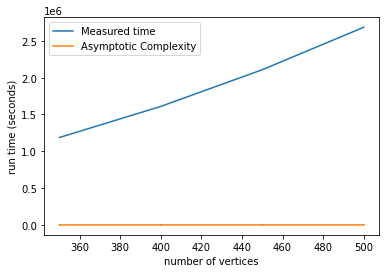

In [392]:
import matplotlib.pyplot as plt 
graph_vertices = [g.V for g in graphs[40:]]
graph_edges = [g.E for g in graphs[40:]]
reference = [3.55e-3*math.pow(V,3)+math.pow(V,2)*math.log2(V) for V in graph_vertices]

plt.plot(graph_vertices,reference)
plt.plot(graph_vertices,running_time[40:])


plt.legend(['Measured time','Asymptotic Complexity'])
plt.ylabel('run time (seconds)')
plt.xlabel('number of vertices')
plt.show()


Average Running-time

In [ ]:
avg_exec = 0
for i in range(len(running_time)):
    avg_exec += running_time[i]
avg_exec /= len(running_time)
print(avg_exec)    
print